# All settings will be given to the channel 1 output, in the Direct out DAC configuration

In [1]:
%matplotlib widget 

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from time import sleep
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import *
import pyqtgraph as pg 
import nidaqmx

In [11]:
M8190A.write('SEQ:DEL:ALL')

# Visa interface for the M8190A instrument:

In [2]:
M8190A = VisaR(AWG_Settings4,60000)

In [5]:
Initialization(M8190A,AWG_Settings4)

Instruments Sampling Frecuency set to 5.00000000000000E+08Hz
Instruments Direct Out DAC Output route Voltage set to 7.00000000000000E-01deciVolts
AWG set to TRIGGERED Mode
Trigger In threshold value set to 1.00000000000000E+00V


In [5]:
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

In [4]:
M8190A.write('*RST')

5

In [5]:
M8190A.query('FREQ:RAST?')

'5.00000000000000E+08'

In [18]:
M8190A.query(':DAC:VOLT:AMPL?')

'7.00000000000000E-01'

In [5]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [4]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


# Loading and triggering a single waveform:

In [6]:
M8190A.query('ARM:TRIG:LEV?')

'1.00000000000000E+00'

In [6]:
M8190A.write('ABOR')

5

In [7]:
test_run = Triggered_Sequence_Setup(PList_secondsA,PList_secondsB,10,5,15,7500000,M8190A,AWG_Settings4,1)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"


In [8]:
test_run[0]['Y1']*AWG_Settings4['Voltage Amplitude']

0           0.0
1          40.0
2          40.0
3          40.0
4          40.0
           ... 
7499995     0.0
7499996     0.0
7499997     0.0
7499998     0.0
7499999     0.0
Name: Y1, Length: 7500000, dtype: float64

In [7]:
test_run[1]['Y1']*AWG_Settings4['Voltage Amplitude']

0           0.0
1          40.0
2          40.0
3          40.0
4          40.0
           ... 
7499995     0.0
7499996     0.0
7499997     0.0
7499998     0.0
7499999     0.0
Name: Y1, Length: 7500000, dtype: float64

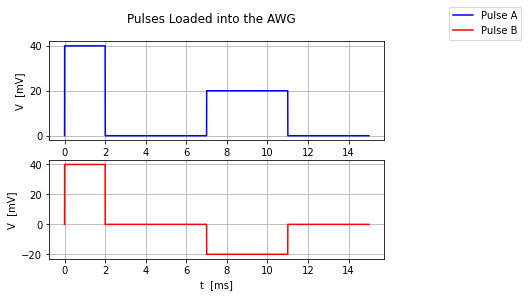

In [9]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulses Loaded into the AWG')


ax[0].plot(test_run[2],test_run[0]['Y1']*AWG_Settings4['Voltage Amplitude'],label= 'Pulse A',color='blue')
ax[1].plot(test_run[2],test_run[1]['Y1']*AWG_Settings4['Voltage Amplitude'],label= 'Pulse B',color='red')
ax[0].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_ylabel('V  [mV]')
ax[1].set_xlabel('t  [ms]')

#ax.set_title('Pulses Loaded into the AWG')

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#fig.savefig('Pulse_scheme_15ms_7500000',optimize=True,bbox_inches='tight')

Triggering Pulse Stoped


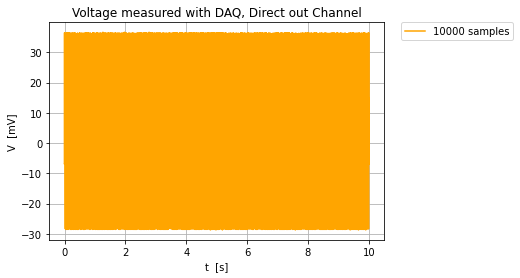

In [11]:
dataM, timeM = DAQ_Measuring(DAQ_Settings1,1000,10,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

plt.plot(timeM,dataM*1000,label= '{b} samples'.format(b=len(dataM)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title('Voltage measured with DAQ, Direct out Channel')
#ax.legend(loc=0)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement noise0',bbox_inches='tight')

# Different behaviour when initializing the AWG outside of the DAQ_measurement function (or inside, but with a time.sleep() right after it) and when initializing the AWG inside the function. Initializing with a delay gives "proper" measurement scheme (I still have to check whether it is getting the correct time scale). This independant of the delay time present when loading a waveform to the awg for the first time after reseting.

In [16]:
dataM.size

10000

output waveform looks better when offset value is set to 0.3mV

In [12]:
a = 3# * e-1

In [13]:
M8190A.write(':DAC1:VOLT:OFFS 0.00{value}'.format(value = a ))

22

Pump = 40mV

ProbeA = 20mV

ProbeB = - 20mV

In [15]:
def DAQ_Measuringms(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(5)



    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime*1e-3) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

Triggering Pulse Stoped


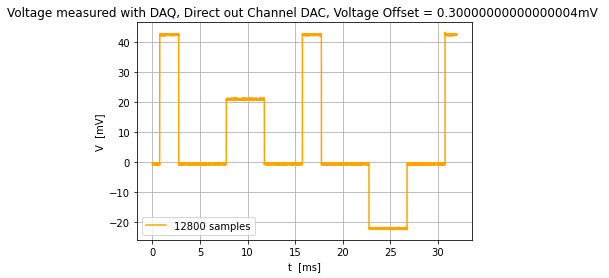

In [16]:
dataMs, timeMs = DAQ_Measuringms(DAQ_Settings1,400000,32,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(timeMs,dataMs*1000,label= '{b} samples'.format(b=len(dataMs)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Voltage measured with DAQ, Direct out Channel DAC, Voltage Offset = {value}mV '.format(value = a*0.1))
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement offset {value}mV '.format(value = a ),bbox_inches='tight')

# Mergin Sweeping loading function with DAQ measuring

In [17]:
def Sequence_File_List(PulseList1,PulseList2,P,t,N,start,stop,AWG):

    """ Given two pulse schemes lists, this functions iterates the pulse scheme from start to stop.

        This function firts creates the corresponding pulse sequence data given the PulseLists using the Sweep_iteration_csv function
        
    """

    #SegmentA of the sequence
    Loc1,DF1,timm = Sweep_Iteration_CSV_List(PulseList1,P,t,N,start,stop,AWG,1)

    #SegmentB of the Sequence
    Loc2,DF2,timm = Sweep_Iteration_CSV_List(PulseList2,P,t,N,start,stop,AWG,0)

    return Loc1, Loc2, DF1,DF2,timm

In [18]:
sweeping_run = Sequence_File_List(PList_secondsA,PList_secondsB,10,15,7500000,0,4,AWG_Settings4)

In [5]:
sweeping_run[0]

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv'}

In [15]:
sweeping_run[0].values()

dict_values(['D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv'])

In [20]:
listt=np.zeros(len(sweeping_run[0]))
for i,j in zip(sweeping_run[0],range(0,len(sweeping_run[0].values()))):
    listt[j] = print(i)

Pulse File Location, at step 0
Pulse File Location, at step 1
Pulse File Location, at step 2
Pulse File Location, at step 3
Pulse File Location, at step 4


In [23]:
listt=[i for i in sweeping_run[0].values]
for i,j in zip(sweeping_run[0].values(),range(0,len(sweeping_run[0]))):
     listt[j] = print(i)

D:\Alejandro\Pulses\Dict\S4\SegmentA_7500000_0.csv


IndexError: list assignment index out of range

In [22]:
len(sweeping_run[0])

5

In [30]:
listt = np.array(sweeping_run[0].values())

In [31]:
listt

array(dict_values(['D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv']),
      dtype=object)

In [9]:
len(sweeping_run[0])

5

In [77]:
def DAQ_Measuringmsl(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in miliseconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(2)



    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime*1e-3) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [25]:
c = np.zeros((2,5))

In [44]:
c[0] = 1

In [45]:
c[0]

array([1., 1., 1., 1., 1.])

In [11]:
def Sequence_Loader_File_DAQ_dictionary(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence. FOR SWEEPING

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    #measurement_data = np.zeros(2,len(fileA))
    measurement_data = {}



    for i,j in zip(fileA, fileB):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data['Data for step {a}'.format(a =i)] = DAQ_Measuringms(DAQ_settings,sampling_rate,playingtime,instrument)[0]
        measurement_data['Time interval step {a}'.format(a =i)] = DAQ_Measuringms(DAQ_settings,sampling_rate,playingtime,instrument)[1]
        #instrument.write('INIT:IMM')
        #time.sleep(2)
        #instrument.query('*OPC?')
        #measurement_data['data result for step {a}and{b}'.format(a =i, b = j)] = DAQ_Measuringmsl(DAQ_settings,sampling_rate,playingtime,instrument)
        instrument.write('ABOR')

    return measurement_data

    

In [28]:
def Sequence_Loader_File_DAQ_np(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence. FOR SWEEPING

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    measurement_data = np.zeros((len(fileA),2),  dtype=object)
    #measurement_data = {}

    for i,j,k in zip(fileA, fileB,range(0,len(fileA))):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data[k][0], measurement_data[k][1] = DAQ_Measuring(DAQ_settings,sampling_rate,playingtime,instrument)
        print('Data acquired for Step {step}'.format(step = k ))
        #instrument.write('ABOR')

    return measurement_data
    

In [25]:
u = np.zeros((len(sweeping_run[0]),2), dtype = object)

for i,j in zip(sweeping_run[0], sweeping_run[1]):
    for k in range(0,len(sweeping_run[0])):
        u[k][0] = k + np.ones(5)
    


In [34]:
u = np.zeros((len(sweeping_run[0]),2), dtype = object)

for i,j,k in zip(sweeping_run[0], sweeping_run[1],range(0,len(sweeping_run[0]))):
    u[k][0] = k + np.ones(5)
    u[k][1] = k*3 + np.ones(5)


In [31]:
np.ones(5) + 1

array([2., 2., 2., 2., 2.])

In [35]:
u[0]

array([array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.])],
      dtype=object)

In [13]:
M8190A.write('*RST')

5

tremendos momazos


In [ ]:
Initialization(M8190A,AWG_Settings4)

desmenuzar

In [29]:
haber = Sequence_Loader_File_DAQms_np(M8190A,DAQ_Settings1,400000,32,sweeping_run[0],sweeping_run[1])

Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 0
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 1
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 2
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 3
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 4


In [57]:
len(haber)

5

In [43]:
haber[3][1]

array([0.00000000e+00, 2.50019533e-03, 5.00039066e-03, ...,
       3.19949996e+01, 3.19974998e+01, 3.20000000e+01])

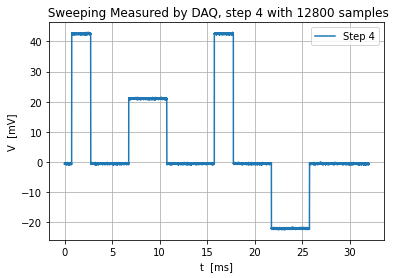

<ipython-input-56-fd91bac2e47e>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('Pulse sweep t=32ms DAQ measured at step {stp} '.format(stp =step),optimize=True,bbox_inches='tight')


In [56]:
#for stepp in range(0,len(haber)):

fig,ax= plt.subplots()

step = 4

ax.grid(True)
plt.plot(haber[step][1],1000*haber[step][0],label= 'Step {st}'.format(st = step ))

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ, step {st} with {b} samples'.format(st = step, b = len(haber[step][1]) ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse sweep t=32ms DAQ measured at step {stp} '.format(stp =step),optimize=True,bbox_inches='tight')

In [67]:
#for stepp in range(0,len(haber)):

fig,ax= plt.subplots()

#step = 4

ax.grid(True)
plt.plot(haber[1][1],1000*haber[1][0],label= 'Step {st}'.format(st = 1 ),color = 'red')
plt.plot(haber[2][1],1000*haber[2][0],label= 'Step {st}'.format(st = 2 ),color = 'orange')
plt.plot(haber[3][1],1000*haber[3][0],label= 'Step {st}'.format(st = 3 ),color = 'blue')
plt.plot(haber[4][1],1000*haber[4][0],label= 'Step {st}'.format(st = 4 ),color = 'purple')



ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ,  {b} samples'.format(st = step, b = len(haber[step][1]) ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse sweep t=32ms DAQ measured, 4 sweeping steps.png',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
u = np.zeros((len(sweeping_run[0]),2), dtype = object)

for i,j in zip(sweeping_run[0], sweeping_run[1]):
    for k in range(0,len(sweeping_run[0])):
        u[k][0] = k + np.ones(5)
    


In [8]:
sweeping_run[0]

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv'}

In [9]:
sweeping_run[1]

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_4.csv'}

In [15]:
sweeping_run[2]

{'SegmentA_7500000_0':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.057143            1              1
 2        0.057143            1              1
 3        0.057143            1              1
 4        0.057143            1              1
 ...           ...          ...            ...
 7499995  0.000000            1              1
 7499996  0.000000            1              1
 7499997  0.000000            1              1
 7499998  0.000000            1              1
 7499999  0.000000            1              1
 
 [7500000 rows x 3 columns],
 'SegmentA_7500000_1':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.057143            1              1
 2        0.057143            1              1
 3        0.057143            1              1
 4        0.057143            1              1
 ...           ...          ...            ...
 7499995  0.000000            1 

In [18]:
sweeping_run[4].size

7500000

In [42]:
haber['Data for step Pulse File Location, at step {st}'.format(st = 0 )]

array([-8.31736646e-05, -2.47801400e-04, -2.47801400e-04, ...,
       -2.47801400e-04, -2.47801400e-04, -5.77056871e-04])

In [40]:
tom = haber['Time interval for step Pulse File Location, at step 0']

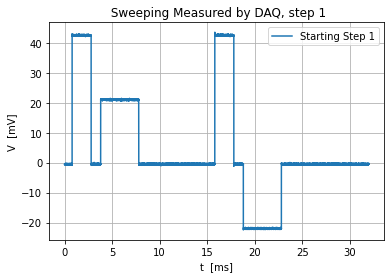

In [44]:
fig,ax= plt.subplots()

step = 1
ax.grid(True)
plt.plot(tom,1000*haber['Data for step Pulse File Location, at step {st}'.format(st = step )],label= 'Starting Step {st}'.format(st = step ))

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ, step {st}'.format(st = step ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

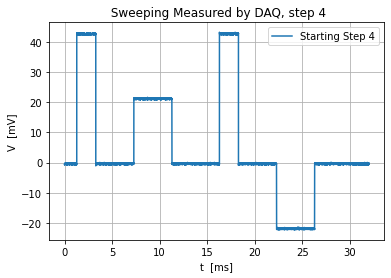

In [46]:
fig,ax= plt.subplots()

step = 4
ax.grid(True)
plt.plot(tom,1000*haber['Data for step Pulse File Location, at step {st}'.format(st = step )],label= 'Starting Step {st}'.format(st = step ))

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ, step {st}'.format(st = step ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [19]:
def DAQ_Measuring(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(2)


    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [8]:
def Sequence_Loader_File_DAQ_np(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence. FOR SWEEPING

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    measurement_data = np.zeros((len(fileA),2),  dtype=object)
    #measurement_data = {}

    for i,j,k in zip(fileA, fileB,range(0,len(fileA))):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data[k][0], measurement_data[k][1] = DAQ_Measuring(DAQ_settings,sampling_rate,playingtime,instrument)
        print('Data acquired for Step {step}'.format(step = k ))
        #instrument.write('ABOR')

    return measurement_data

In [ ]:
dataM, timeM = DAQ_Measuring(DAQ_Settings1,1000,10,M8190A)

In [9]:
hober = Sequence_Loader_File_DAQ_np(M8190A,DAQ_Settings1,1000,10,sweeping_run[0],sweeping_run[1])

Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 0
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 1
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 2
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 3
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 4


In [21]:
hober[0][0].size

10000

In [25]:
tom

array([0.00000000e+00, 1.00010001e-03, 2.00020002e-03, ...,
       9.99799980e+00, 9.99899990e+00, 1.00000000e+01])

In [24]:
tom = hober[0][1]

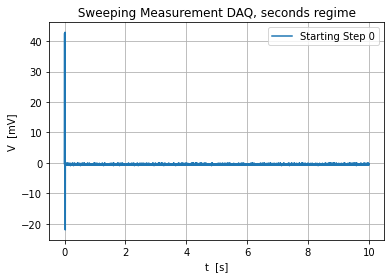

In [31]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(tom,1000*hober[3][0],label= 'Starting Step 0')
#plt.plot(tom,1000*hober[1][0],label= '1')
#plt.plot(tom,hober[2][0],label= '2')
#plt.plot(tom,hober[3][0],label= '3')
#plt.plot(tom,hober[4][0],label= '4')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title(' Sweeping Measurement DAQ, seconds regime ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [12]:
M8190A.query('OUTP:ROUT:SEL?')

'DAC'

In [11]:
M8190A.write('OUTP:ROUT:SEL DAC')

18

In [17]:
M8190A.write('INIT:IMM')

9

voltask =  nidaqmx.Task()

voltask.ao_channels.add_ao_voltage_chan("DAQBNC1/ao1",min_val=-3,max_val=3)




print('Task started')
voltask.start()

time.sleep(10)

print('Writting!')

time.sleep(4)
voltask.write(3)
time.sleep(7) 

print('Lowering Voltage!')
time.sleep(4)

voltask.write(0)
#
voltask.stop()
#
voltask.close()